# Lexical Category Analysis with LIWC
A way to analyze any DTRS dataset using lexical categories from LIWC.
Uses the liwc library, [install from GitHub](https://github.com/evanll/liwc-text-analysis-python)

In [1]:
import sys
import re
import glob
import spacy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import Markdown, display
from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups

In [2]:
def printmd(string):
    display(Markdown(string))

## Load DTRS datasets
Load pre-processed DTRS datasets into a dataframe

In [3]:
files = glob.glob('./output/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 65 files and loaded 20902 rows into the dataframe.


In [4]:
df[0:10]

,dataset,session,speaker,utterance
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn."
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about..."
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.


## Extract List of Terms from LIWC
The list below is a placeholder. Ideally we would like to replace the list below with a list of category terms from LIWC.

In [5]:
liwc_test = ["swim", "walk", "paddle", "ride", "crawl", "scoot", "paddling",
     "drag", "swim", "waddle", "gallop", "jump", "Swim", "feet", "fly",
     "pedal", "trail", "skate", "slip", "haul", "slide", "jog", "jog",
     "crawl", "climb_trees", "chase", "walk", "faceplant", "boat",
     "catch", "knuckle", "riding", "hike", "fling", "uphill",
     "snowboard", "swimming", "long_board", "float", "hop", "sprint",
     "raft", "bonk", "hike", "walk/run", "dismount", "mosey", "limp",
     "train", "scurry", "whack", "ditch", "skateboard", "duck", "kayak",
     "huck", "ski", "saunter", "wheel", "dart", "paddling", "sideways",
     "sail", "plow", "yank", "fly", "loaf", "dive", "head", "drive",
     "legs", "kayak", "town", "lumber", "lay", "step", "skateboard",
     "hump", "sit", "climb", "shimmy", "pound", "scoot", "trail", "zip",
     "soft_sand", "long_ride", "feet", "glide", "trudge", "deep_water",
     "skid", "strap", "beach", "putter", "maneuver"]

liwc_tentative = ["pretty", "confused", "hesitant", "hopefully", "confusing", "hoping",
    "doubt", "doubting", "hope", "confuse", "hoped", "luck", "lucky", "any",
    "questions", "kind of", "probably", "something", "or", "anything",
    "may", "some", "try", "perhaps", "if", "possible", "bet", "guess",
    "anyhow", "most", "quite", "might", "sort", "somewhat", "assuming",
    "supposed", "seem", "somebody", "maybe", "someone", "assume", "trying",
    "lot", "question", "sometimes", "option", "dunno", "approximately",
    "sorta", "generally", "options", "possibility", "kinda", "overall",
    "seems", "wondering", "somewhere", "sometime", "assumption",
    "potentially", "possibly", "optional", "optionally", "mostly", "almost",
    "depending", "often", "seemed", "potential", "temporarily",
    "occasionally", "wonder", "someone's", "lots", "opinion", "apparently",
    "somehow", "somebody's", "suppose", "barely", "usually", "random",
    "vary", "anywhere", "puzzle", "practically", "fairly", "wondered",
    "depends", "appears", "unknown", "assumed", "probablyâ", "unlikely",
    "mainly", "something's", "vaguely", "sorts", "theory", "chance",
    "typically", "possibleâ", "confusion", "virtually", "anyone",
    "appearing", "depend", "anybody", "likely", "unclear", "supposing",
    "possibilities", "appear", "alot", "border", "assumes", "guessing",
    "hardly", "anytime", "temporary", "randomly", "lotta", "hypothetical",
    "contingent", "someday", "undecided", "hypothesize", "blurred",
    "variable", "theoretically", "partly", "borderline", "variables",
    "feasible", "confusions", "somethingo", "mystery", "questioning",
    "assumptions", "possibilites", "betting", "indirectly", "supposedly",
    "varies", "vague", "temporally", "indirect", "puzzling"]


In [7]:
liwc_tentative.sort()
print(liwc_tentative)
liwc_tentative_groups = [
    {"group" : "almost", "entries" : ["almost"]}
]
# print([x for x in liwc_tentative if len(x.split(" ")) > 1])

['almost', 'alot', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anytime', 'anywhere', 'apparently', 'appear', 'appearing', 'appears', 'approximately', 'assume', 'assumed', 'assumes', 'assuming', 'assumption', 'assumptions', 'barely', 'bet', 'betting', 'blurred', 'border', 'borderline', 'chance', 'confuse', 'confused', 'confusing', 'confusion', 'confusions', 'contingent', 'depend', 'depending', 'depends', 'doubt', 'doubting', 'dunno', 'fairly', 'feasible', 'generally', 'guess', 'guessing', 'hardly', 'hesitant', 'hope', 'hoped', 'hopefully', 'hoping', 'hypothesize', 'hypothetical', 'if', 'indirect', 'indirectly', 'kind of', 'kinda', 'likely', 'lot', 'lots', 'lotta', 'luck', 'lucky', 'mainly', 'may', 'maybe', 'might', 'most', 'mostly', 'mystery', 'occasionally', 'often', 'opinion', 'option', 'optional', 'optionally', 'options', 'or', 'overall', 'partly', 'perhaps', 'possibilites', 'possibilities', 'possibility', 'possible', 'possibleâ', 'possibly', 'potential', 'potentially', 'pract

In [8]:
# hypothetical_indicators = ["would", "could", "can", "might", "may", "if", "then", "unless"]


def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence)))
    return num_matches
    

## Counting Relevant Terms in the Dataset
We count the number of terms in each utterance that also exist in the above list of category terms. This term count is added as a separate column (in this case called `liwc_test`).

In [9]:
def add_liwc_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    liwc_measures = []
    for ind, utterance in enumerate(list(df['utterance'])) :
        if utterance != '' and utterance != ' ' :
            liwc_measure = count_lexicon_terms(utterance, lex_category_list)
            liwc_measures.append(liwc_measure)
    df.insert(column_index, lex_category_name, liwc_measures, True)
    return df


In [10]:
df = add_liwc_measure(df, 'liwc_tentative', liwc_tentative)
df[0:10]

,dataset,session,speaker,utterance,liwc_tentative
0,dtrs-10,grad-2-concept-review-sharon,Steve,Next. Okay whose turn? Wilson?,0
1,dtrs-10,grad-2-concept-review-sharon,Wilson,Huh?,0
2,dtrs-10,grad-2-concept-review-sharon,Steve,"You’re talking, it’s your turn.",0
3,dtrs-10,grad-2-concept-review-sharon,Wilson,It’s my turn?,0
4,dtrs-10,grad-2-concept-review-sharon,Steve,You critique it. What’s working. Explain the...,0
5,dtrs-10,grad-2-concept-review-sharon,Wilson,Let me take a look. Uh. So it is uh a coat h...,1
6,dtrs-10,grad-2-concept-review-sharon,Steve,"OK. It makes sense. Okay, what is good about...",1
7,dtrs-10,grad-2-concept-review-sharon,Wilson,I think the storyboard it make very good sense.,0
8,dtrs-10,grad-2-concept-review-sharon,Steve,Okay.,0
9,dtrs-10,grad-2-concept-review-sharon,Wilson,Yes.,0


In [11]:
def round_to_multiples(x, multiples_of=5):
    base = multiples_of
    if base == 0 :
        return base
    else :
        return base * round(x/base)
    
def round2(x):
    y = round(x, 2)
    return y

def plot_measure(df, dataset, session, measure):
    df0=df[df['dataset']==dataset]
    if session != '' :
        df1=df0[df0['session']==session]
    else :
        df1 = df0
    fig = plt.figure(figsize=[10,2], dpi=300)
    col = sns.color_palette("Set2")
    sns.set_style('ticks', {'axes.linewidth': 0.5, 'axes.edgecolor':'grey', 'axes.spinecolor' : 'grey'})
    sns.set_context('paper', font_scale = 1)
    ax = sns.barplot(x=df1.index, y=measure, data=df1, hue='speaker', palette ='Set2', linewidth=0)
    data_len = df1.shape[0]
    rounding_factor = int(data_len/50)
    xlim = df1.shape[0] + 1
    if rounding_factor > 0 :
        xlist = list(np.arange(0, xlim, round_to_multiples(xlim/20, multiples_of=rounding_factor)))
    else :
        xlist = list(np.arange(0, xlim))
    ax.set_xticks(xlist)
    ax.set_xticklabels(ax.get_xticks(), fontsize=7)
    ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)
    ax.set_ylabel(measure, fontsize=9)
    plt.title("# words vs. # utterances: " + dataset +' | '+ session +' | '+ measure, fontsize=9)
    speakers = len(set(list(df1['speaker'])))
    legend_columns = round(speakers/4) + 1
    plt.legend(loc='best', ncol=legend_columns, borderaxespad=0.15)
    plt.savefig('./plots/'+ dataset +'-'+ session +'-'+ measure +'.pdf', bbox_inches='tight')

In [12]:
def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance_old(text, word, width=80, occurrences=25):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        if ind < margin :
            spaces_left = " " * (margin - ind)
            margin_left = ind
            string_left = spaces_left + text[start:margin_left]
        else :
            margin_left = start + margin
            string_left = text[start:margin_left]
            
        if ind+len(word)+margin > len(text) :
            spaces_right = " " * (ind+len(word)+margin - len(text))
            margin_right = len(text)
            string_right = text[ind+len(word):margin_right] + spaces_right
        else :
            margin_right = ind + len(word) + margin
            string_right = text[ind+len(word):margin_right]
        print(string_left + "  " + word + "  " + string_right)
        start += ind + len(word)
        counter += 1
        
def concordance(text, word, width=80, occurrences=25,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df, dataset, session, lexicon, filter_keywords=[], match_limit=10, nospace=False):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['utterance'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)
    
  

## Dataset Information as Reference for Plotting
Down below you will see a table of all datasets and sessions. You can use them as inputs to plot the lexical categories for any one dataset and session.

In [13]:
df_data = df.drop(['speaker', 'utterance', 'liwc_tentative'], axis=1)
df_data = df_data.drop_duplicates(subset=None, keep='first', inplace=False)
df_data = df_data.reset_index()
df_data[df_data['dataset'] == 'dtrs-02'].sort_values('session')

,index,dataset,session
52,16295,dtrs-02,think-aloud
31,9231,dtrs-02,three-person-discussion


In [14]:
df_data[df_data['dataset'] == 'dtrs-07'].sort_values('session')

,index,dataset,session
10,1597,dtrs-07,crematorium-meeting-01
12,2619,dtrs-07,crematorium-meeting-02
55,17060,dtrs-07,engineers-meeting-01
61,19574,dtrs-07,engineers-meeting-02


In [15]:
df_data[df_data['dataset'] == 'dtrs-10'].sort_values('session')

,index,dataset,session
7,740,dtrs-10,grad-1-search-review-amie-jin
6,461,dtrs-10,grad-1-search-review-marlen-david
14,3950,dtrs-10,grad-1-search-review-sharon-ellen
58,18589,dtrs-10,grad-2-concept-review-amie
41,13182,dtrs-10,grad-2-concept-review-ellen
48,16058,dtrs-10,grad-2-concept-review-marlen
0,0,dtrs-10,grad-2-concept-review-sharon
9,1142,dtrs-10,grad-2-concept-review-wilson
3,319,dtrs-10,grad-3-client-review-ellen
40,13098,dtrs-10,grad-3-client-review-jin


In [16]:
df_data[df_data['dataset'] == 'dtrs-11'].sort_values('session')

,index,dataset,session
39,12996,dtrs-11,01-background-interview
36,12730,dtrs-11,02-designing-cocreation-workshops
34,11701,dtrs-11,03-iterations-on-workshop-design
21,6202,dtrs-11,04-iterations-on-cocreation-workshops
15,4184,dtrs-11,05-designing-cocreation-workshops-day-2
30,9071,dtrs-11,07-designing-cocreation-workshops-debrief-day-1
45,14696,dtrs-11,08-sharing-insights-from-cocreation-workshops-...
35,12256,dtrs-11,09-clustering-insights-cc1
28,8421,dtrs-11,10-iterations-on-cc2-design
46,15036,dtrs-11,11-linking-insights-from-cc-to-project


## Plot Occurrences
Plot Lexical categories for any dataset and session.

<ipython-input-11-d5e0bb820a79>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)


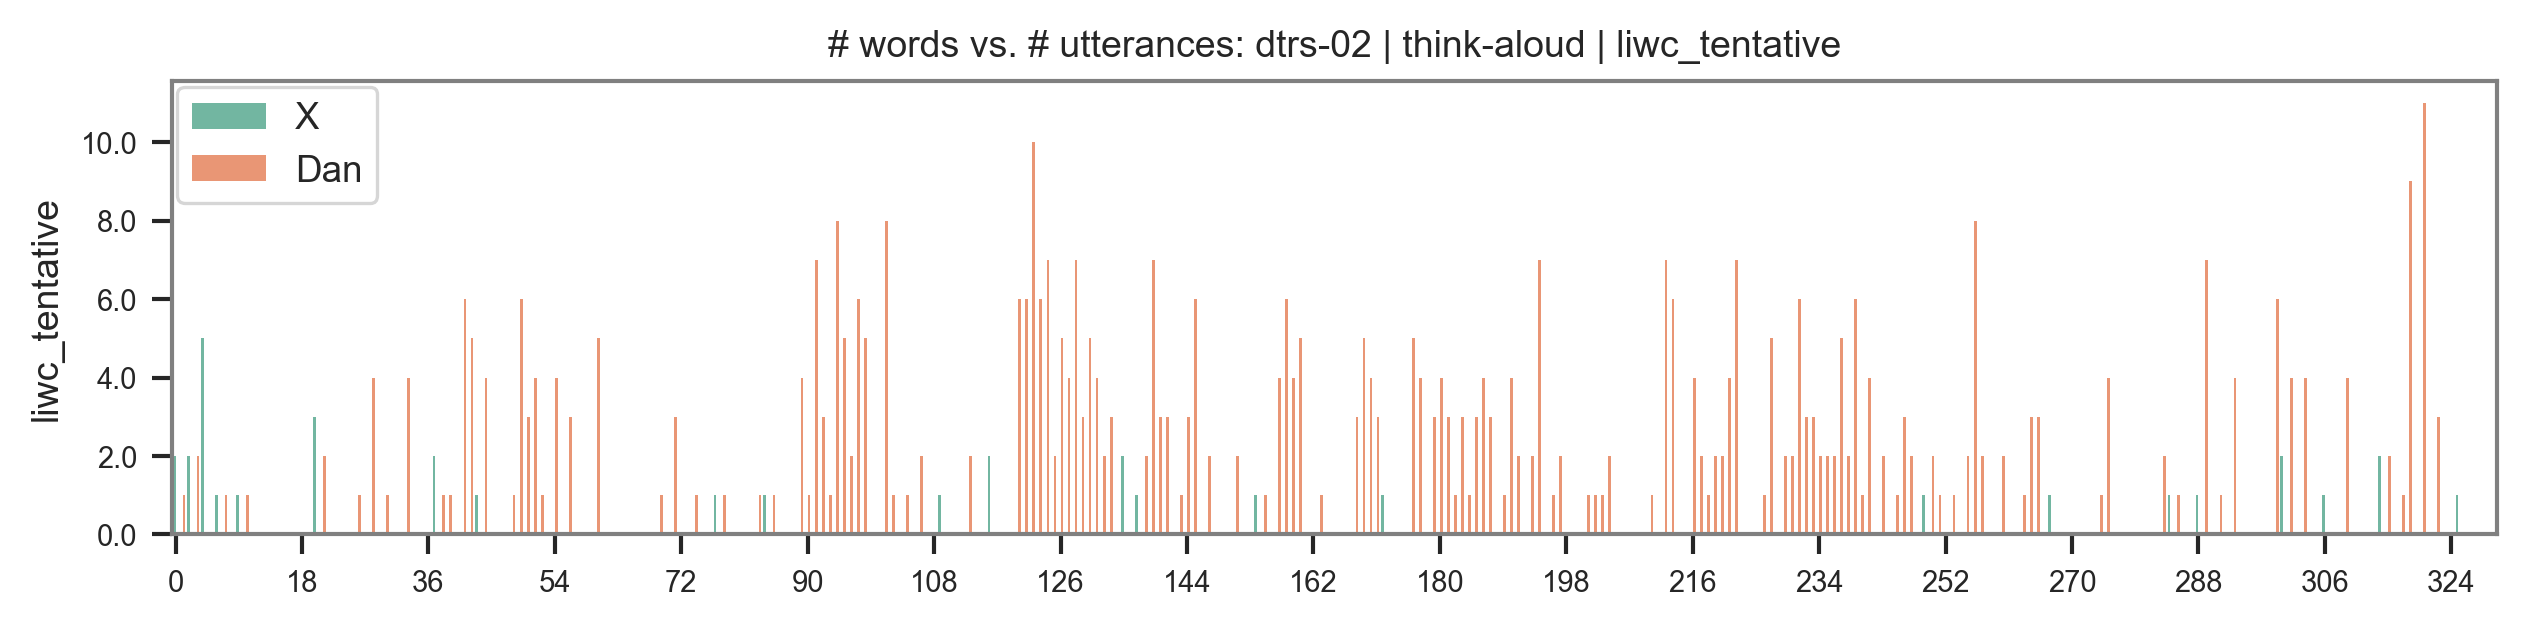

In [17]:
plot_measure(df, 'dtrs-02', 'think-aloud', 'liwc_tentative')

## Examine Specifics
Examine utterances in detail and show overlaps with terms in the lexical category.

In [18]:
print_lines(df, 'dtrs-02', 'think-aloud', liwc_tentative, 0, num_lines=5)

0 : X


before i give you the design brief, are there **any** **questions** about the procedure? (00:14:00)

----------
1 : Dan


um no, other than the ....i have these two references here, the file of information that you have um.. i will just ask you for..what?., identify..i say what **kind of** technical information i want?

----------
2 : X


yes. **probably** after you’ve read the brief you will think 'oh, well there's... i would like to know **something** more about, this, **or**, er, i would, you know, ..do you have the information on such and such a topic?’

----------
3 : Dan


alright. but you don't have the directory **or** **anything** to give me? no

----------
4 : X


no. the idea is not to to give you the... i mean this is..there.. we've just put together stuff which **may** be useful, we don't know what people will ask for so there's a file of stuff, **some** of it **may** be useful, **some** of it **may** be completely irrelevant.

----------


In [19]:
print_concordances(df, 'dtrs-02', 'think-aloud', liwc_tentative, filter_keywords=['any', 'question', 'kind of', 'probably', 'something'], match_limit=10, nospace=True)

 give you the design brief, are there any questions about the procedure? (00:14 : 46
. But you don't have the directory or anything to give me? No No. The idea is n : 543
liminary design for the device em but anyhow that'll show me that in this em..  : 3332
e in the past and having ridden over many mountains er unfortunately not on a m : 6016
o em know that the Blackbird {jo, company I believe is in Cupertino em so it's  : 9995
backpack this heavy em er framepacks many people don’t carry their sleeping bag : 20084
f that and that is that em er the company gets to sell more of these little bra : 41909
--------------------------------------------------------------------------------
you the design brief, are there any questions about the procedure? (00:14:00) Um : 50
 em full em er I'm going to ask one question while I'm at it here em can you sho : 17103
e bicycle alright em now I have one question for for you er I'm am I to assume t : 33099
-----------------------------------------------

In [20]:
print_concordances(df, 'dtrs-02', 'think-aloud', liwc_tentative, filter_keywords=['any', 'question', 'kind of', 'probably', 'something'], match_limit=20)

 give you the design brief, are there   any   questions about the procedure? (00:14 : 46
. But you don't have the directory or   any  thing to give me? No No. The idea is n : 543
liminary design for the device em but   any  how that'll show me that in this em..  : 3332
e in the past and having ridden over m  any   mountains er unfortunately not on a m : 6016
o em know that the Blackbird {jo, comp  any   I believe is in Cupertino em so it's  : 9995
backpack this heavy em er framepacks m  any   people don’t carry their sleeping bag : 20084
f that and that is that em er the comp  any   gets to sell more of these little bra : 41909
--------------------------------------------------------------------------------
you the design brief, are there any   question  s about the procedure? (00:14:00) Um : 50
 em full em er I'm going to ask one   question   while I'm at it here em can you sho : 17103
e bicycle alright em now I have one   question   for for you er I'm am I to assume t : 33099
-------

<ipython-input-11-d5e0bb820a79>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(map(round2, ax.get_yticks()), fontsize=7)


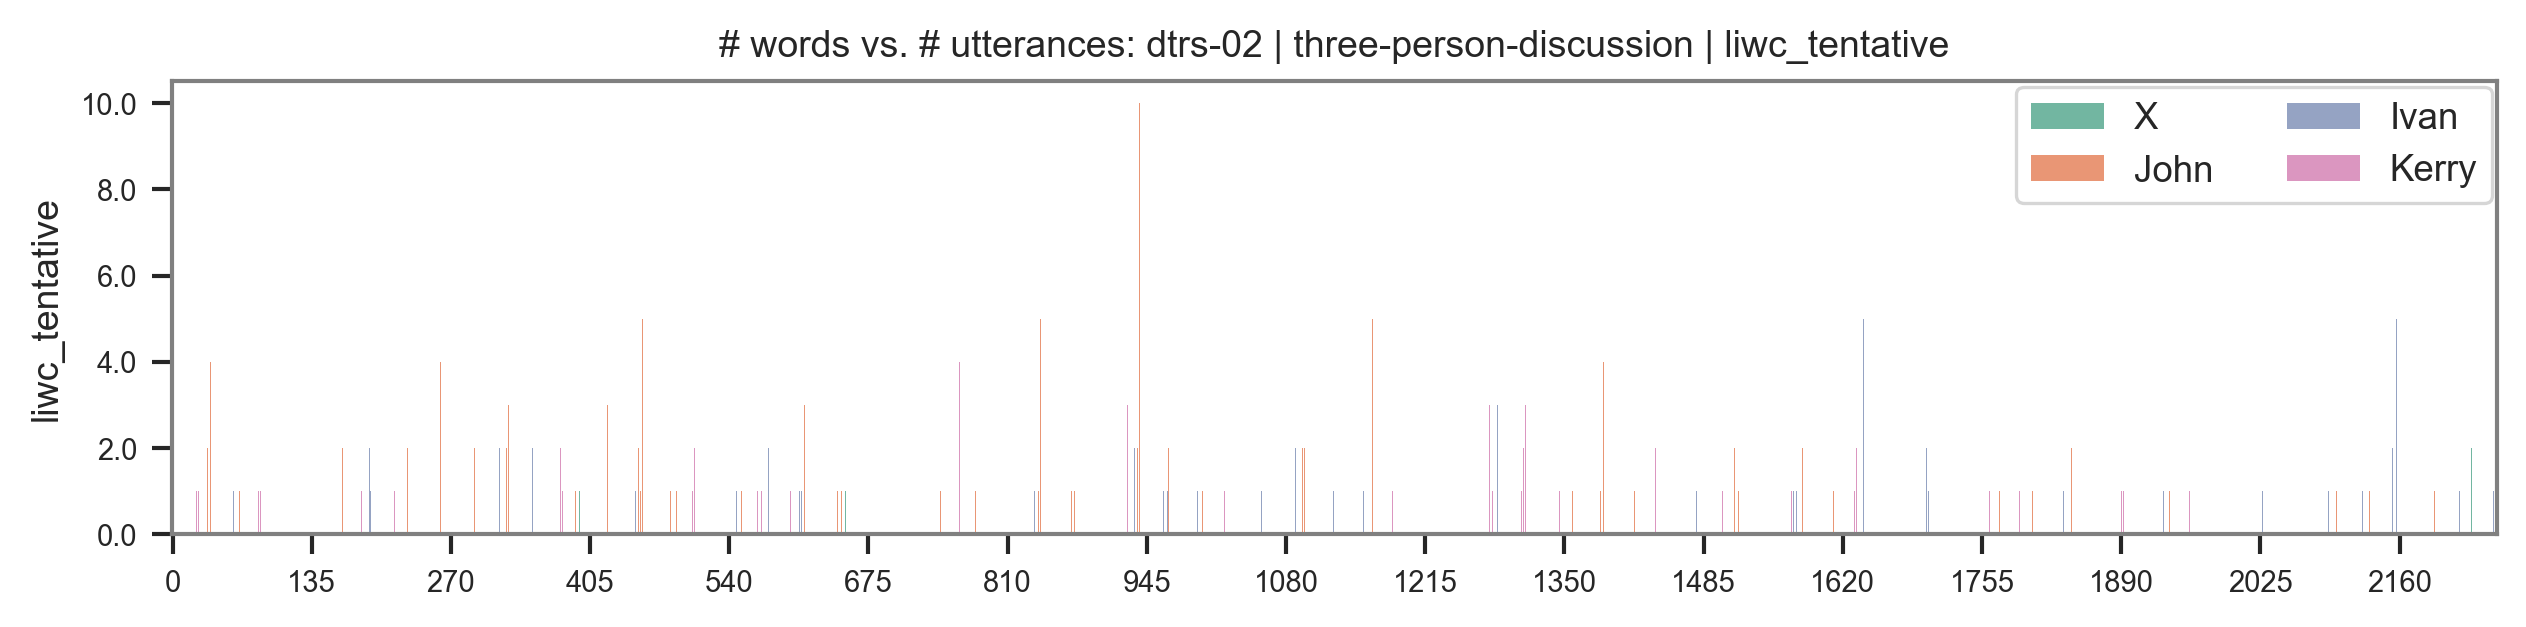

In [21]:
plot_measure(df, 'dtrs-02', 'three-person-discussion', 'liwc_tentative')